# Accessing MapStand WFS Data with GeoPandas

This tutorial walks you through:
- Connecting to a Web Feature Service (WFS) endpoint
- Downloading GeoJSON data with requests
- Loading it into GeoPandas
- Performing a spatial join to find nearest features

## Prerequisites
Before starting, make sure you have the following libraries installed:

`pip install geopandas requests geojson python-dotenv`

You’ll also need an API key (in this example, from MapStand).
Create a .env file in your working directory and add your key:

`MPS_API_KEY=your_api_key_here`

Details on how to find your API access token can be found [here](https://support.mapstand.com/api-access-token)

## Step 1: Import Libraries and Load Environment Variables

In [1]:
import geopandas as gpd
import requests
import geojson
import os
from dotenv import load_dotenv

# Load API keys and environment variables
load_dotenv()

True

## Step 2: Define a Helper Function to Read WFS Data
Before fetching multiple WFS layers, it’s helpful to create a helper function. This avoids repeating the same request and parsing steps, making your code cleaner and easier to reuse.

In [2]:
def read_wfs(url, params, typename, crs='EPSG:4326', cql_filter=""):
    """
    Fetch a WFS layer and return it as a GeoDataFrame.

    Args:
        url (str): WFS base URL
        params (dict): Common WFS parameters
        typename (str): Name of the layer to request
        crs (str): Coordinate Reference System (default: 'EPSG:4326')
        cql_filter (str): Optional CQL filter for querying features

    Returns:
        geopandas.GeoDataFrame: The requested layer as a GeoDataFrame
    """
    params = params.copy()
    params.update({
        "typename": typename,
        "srsName": crs,
        "CQL_FILTER": cql_filter
    })

    response = requests.get(url, params=params)
    response.raise_for_status()

    data = geojson.loads(response.content)
    gdf = gpd.GeoDataFrame.from_features(data, crs=crs)

    print(f"Loaded {len(gdf)} features from {typename}")
    return gdf

## Step 3: Define WFS Connection Parameters
Details of connection parameters and how to find typenames can be found at [here](https://support.mapstand.com/ogc-web-services).

In [3]:
url = "https://hub.mapstand.com/gs/ows?"

params = {
    "version": "1.3.0",
    "service": "WFS",
    "request": "GetFeature",
    "outputFormat": "application/json",
    "apikey": os.getenv('MPS_API_KEY')
}

crs = 'EPSG:3857'  # Web Mercator projection used for distance calculation in meters
cql_filter = "glbl_country = 'United Kingdom'"

## Step 4: Fetch Geospatial Layers
We’ll pull two layers:
- Industrial facilities
- Hydrogen plants

In [4]:
industrial_facility_gdf = read_wfs(
    url, params, "phoenix:industrial_facility", crs, cql_filter
)

hydrogen_plant_gdf = read_wfs(
    url, params, "phoenix:hydrogen_plant", crs, cql_filter
)

Loaded 1729 features from phoenix:industrial_facility
Loaded 283 features from phoenix:hydrogen_plant


## Step 5: Perform Spatial Calculations
For this example we're going to perform a spatial join to find the nearest hydrogen plant to each industrial facility.
GeoPandas provides a very handy function: gpd.sjoin_nearest()
 This matches each feature from the left GeoDataFrame with its nearest neighbor from the right.

In [6]:
nearest = gpd.sjoin_nearest(
    industrial_facility_gdf,
    hydrogen_plant_gdf,
    how="left",
    max_distance=10_000,  # limit to 10 km
    distance_col="distance_m",
    lsuffix="industrial_facility",
    rsuffix="hydrogen_plant"
)

## Step 6: Save the Result (Optional)
You can save your joined dataset to a GeoPackage or Shapefile:

In [7]:
nearest.to_file("nearest_hydrogen_facilities.gpkg", layer="uk_facilities", driver="GPKG")

## Step 7: Visualize (Optional)
Quick map preview using GeoPandas and matplotlib tools:

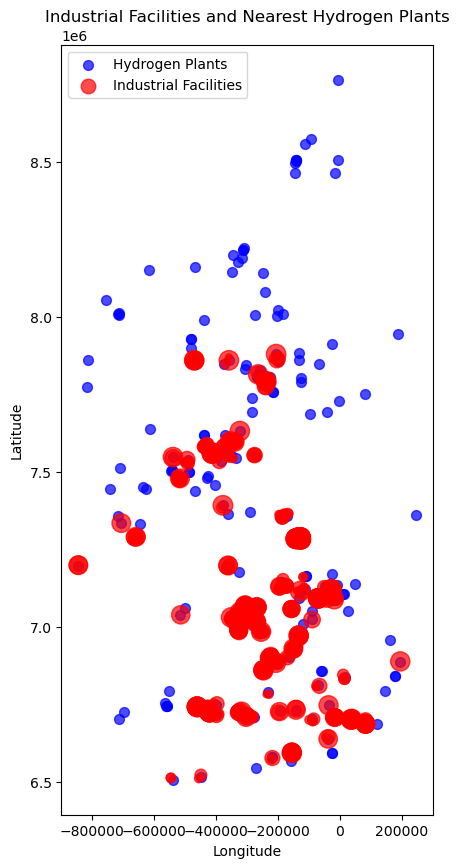

In [13]:
import matplotlib.pyplot as plt

# Only keep industrial facilities that successfully matched a hydrogen plant
joined_facilities = nearest.dropna(subset=['distance_m'])

# Scale marker size based on distance (closer → larger)
max_size = 200
min_size = 20
distances = joined_facilities['distance_m']
marker_sizes = min_size + (distances.max() - distances) / distances.max() * (max_size - min_size)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot hydrogen plants
hydrogen_plant_gdf.plot(
    ax=ax, color='blue', markersize=50, label='Hydrogen Plants', alpha=0.7
)

# Plot industrial facilities (matched) with size scaled by distance
joined_facilities.plot(
    ax=ax, color='red', markersize=marker_sizes, label='Industrial Facilities', alpha=0.7
)

plt.title("Industrial Facilities and Nearest Hydrogen Plants")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Resources 
https://support.mapstand.com/api-access-token

https://support.mapstand.com/ogc-web-services

https://docs.geoserver.org/main/en/user/services/wfs/reference.html

https://geopandas.org/en/stable/docs.html